In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0804"
name_notebook = day + "-sq_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_angles(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

# X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
# X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 3,
    block_n_layers = 25,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

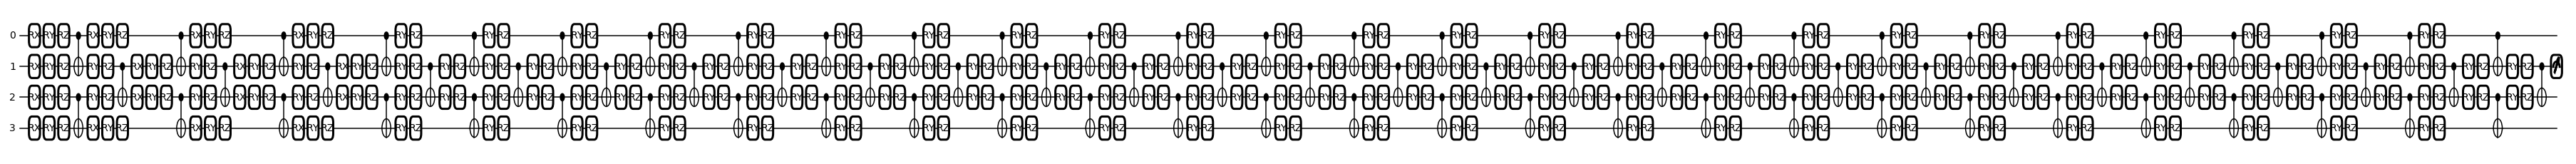

In [10]:
quantum_layer.draw(size=(50,3))

# Quantum model

In [11]:
layers = [quantum_layer()]

In [12]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
    # keep_track_params=True,
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [13]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

0.5760897907912296
-0.5713941893561582


In [14]:
model.keep_track_params=True,

In [15]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 2.0825, Loss validation: 2.2491


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.0559, 	 target: 0.0515, 	 loss: 2.0857
	 Validation string, 	 i: 1; 	 prediction: 0.3582, 	 target: 0.1220, 	 loss: 1.9349
	 Validation string, 	 i: 2; 	 prediction: 0.1937, 	 target: 0.0732, 	 loss: 1.6445
Epoch [1/50], Loss: 2.1732, Loss validation: 2.3461, Time remaining: ~0.0h 52.0m 40s
	 Validation string, 	 i: 0; 	 prediction: -0.0309, 	 target: 0.0515, 	 loss: 1.5996
	 Validation string, 	 i: 1; 	 prediction: -0.4060, 	 target: 0.1220, 	 loss: 4.3270
	 Validation string, 	 i: 2; 	 prediction: -0.4290, 	 target: 0.0732, 	 loss: 6.8581
Epoch [2/50], Loss: 2.2002, Loss validation: 2.5655, Time remaining: ~0.0h 48.0m 56s
	 Validation string, 	 i: 0; 	 prediction: -0.1359, 	 target: 0.0515, 	 loss: 3.6415
	 Validation string, 	 i: 1; 	 prediction: 0.0703, 	 target: 0.1220, 	 loss: 0.4238
	 Validation string, 	 i: 2; 	 prediction: -0.0099, 	 target: 0.0732, 	 loss: 1.1354
Epoch [3/50], Loss: 2.1783, Loss validation: 2.1242, Time remaining:

In [16]:
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0804/txts/0804-sq_1qm_model_str_2.txt


In [17]:
model.save_state_dict(
    intermediate = True,
)

Model saved as peptide-QML/checkpoints/0804/models/0804-sq_1qm_2.pth and intermediate parameters saved in peptide-QML/checkpoints/0804/models/0804-sq_1qm_2


Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_batches_2.png


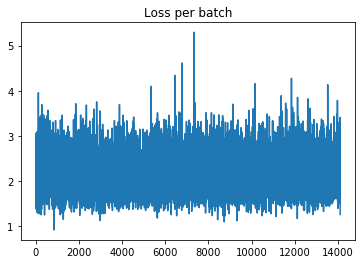

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_2.png


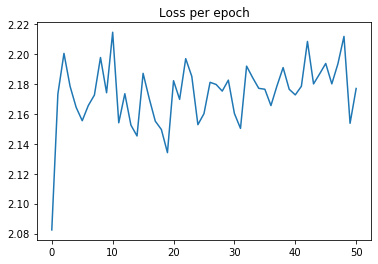

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_validation_2.png


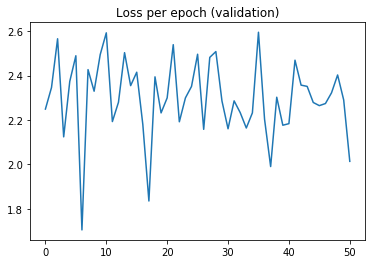

In [18]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.embedding_weights_None_2.png


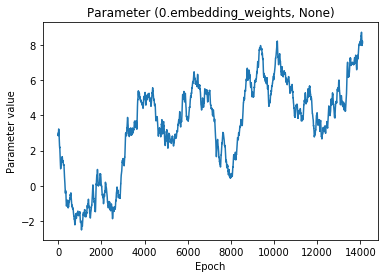

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.block_weights_None_2.png


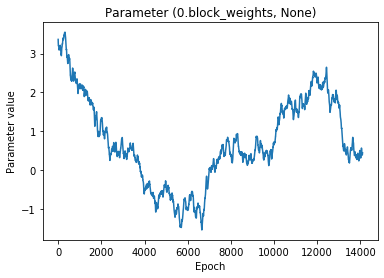

In [19]:
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [20]:
# model.plot_parameter(layer='0.block_weights', index=50)

In [21]:
# print validation
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.0515, 	 output: -0.2552, 	 loss: 5.9590
i: 1, 		 target: -0.0912, 	 output: -0.1246, 	 loss: 0.3662
i: 2, 		 target: -0.0766, 	 output: -0.2297, 	 loss: 1.9975
i: 3, 		 target: 0.0084, 	 output: 0.2009, 	 loss: 22.9781
i: 4, 		 target: -0.0786, 	 output: -0.1705, 	 loss: 1.1685
i: 5, 		 target: -0.0502, 	 output: -0.0337, 	 loss: 0.3282
i: 6, 		 target: -0.0818, 	 output: -0.1751, 	 loss: 1.1411
i: 7, 		 target: 0.1073, 	 output: 0.0597, 	 loss: 0.4436
i: 8, 		 target: -0.0444, 	 output: 0.0873, 	 loss: 2.9656
i: 9, 		 target: 0.0427, 	 output: -0.1144, 	 loss: 3.6770
i: 10, 		 target: 0.1220, 	 output: -0.0159, 	 loss: 1.1304
i: 11, 		 target: 0.1228, 	 output: 0.1273, 	 loss: 0.0368
i: 12, 		 target: -0.0850, 	 output: -0.1419, 	 loss: 0.6706
i: 13, 		 target: 0.1281, 	 output: -0.4984, 	 loss: 4.8913
i: 14, 		 target: 0.1416, 	 output: -0.3403, 	 loss: 3.4043
i: 15, 		 target: -0.0622, 	 output: -0.2317, 	 loss: 2.7245
i: 16, 		 target: 0.0263, 	 output: -0.1842, 

In [22]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[main 13e0379] data trained model
 14116 files changed, 1031 insertions(+)
 create mode 100644 checkpoints/0804/models/.gitkeep
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00000.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00001.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00002.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00003.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00004.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00005.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00006.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict_00007.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_2/state_dict